In [55]:
import os 
import pickle 
import numpy as np
from tqdm.notebook import tqdm

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add
from tensorflow.keras.models import load_model
import cv2

In [56]:
# load feature
with open('/content/drive/MyDrive/Data Science Datasets/features (4).pkl', 'rb') as f:
    features = pickle.load(f)

In [57]:
with open('/content/drive/MyDrive/Data Science Datasets/captions.txt', 'r') as f:
    next(f)
    captions_doc = f.read()

In [58]:
# create mapping of image to captions
mapping = {}

for line in tqdm(captions_doc.split('\n')):
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    image_id = image_id.split('.')[0]
    caption = ' '.join(caption)
    if image_id not in mapping:
        mapping[image_id] = []
    mapping[image_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

In [59]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            caption = captions[i]
            caption = caption.lower()
            #Remove digits, special characters
            caption = caption.replace('[^A-Za-z]', '')
            #Remove Extra spaces
            caption = caption.replace('\s+', ' ')
            caption = 'nstartn ' + " ".join([word for word in caption.split() if len(word)>1]) + ' nendn'
            captions[i] = caption

In [60]:
clean(mapping)

In [61]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [62]:
# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [63]:
# get maximum length of the caption available 
max_length = max(len(caption.split()) for caption in all_captions)
max_length 

35

In [64]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

In [65]:
model1 = load_model('/content/drive/MyDrive/Data Science Datasets/Image_Caption_Genreation_Model_2.h5')

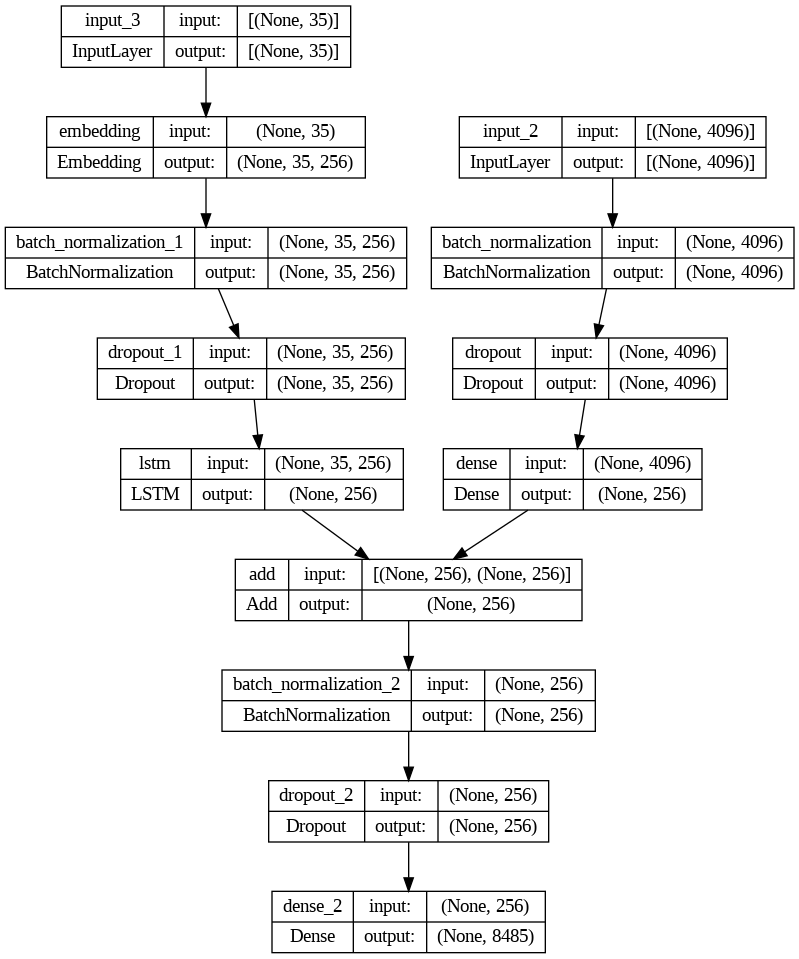

In [66]:
plot_model(model1, show_shapes=True)

In [67]:
model2 = load_model('/content/drive/MyDrive/Data Science Datasets/Image_Caption_Genreation_Model_3.h5')

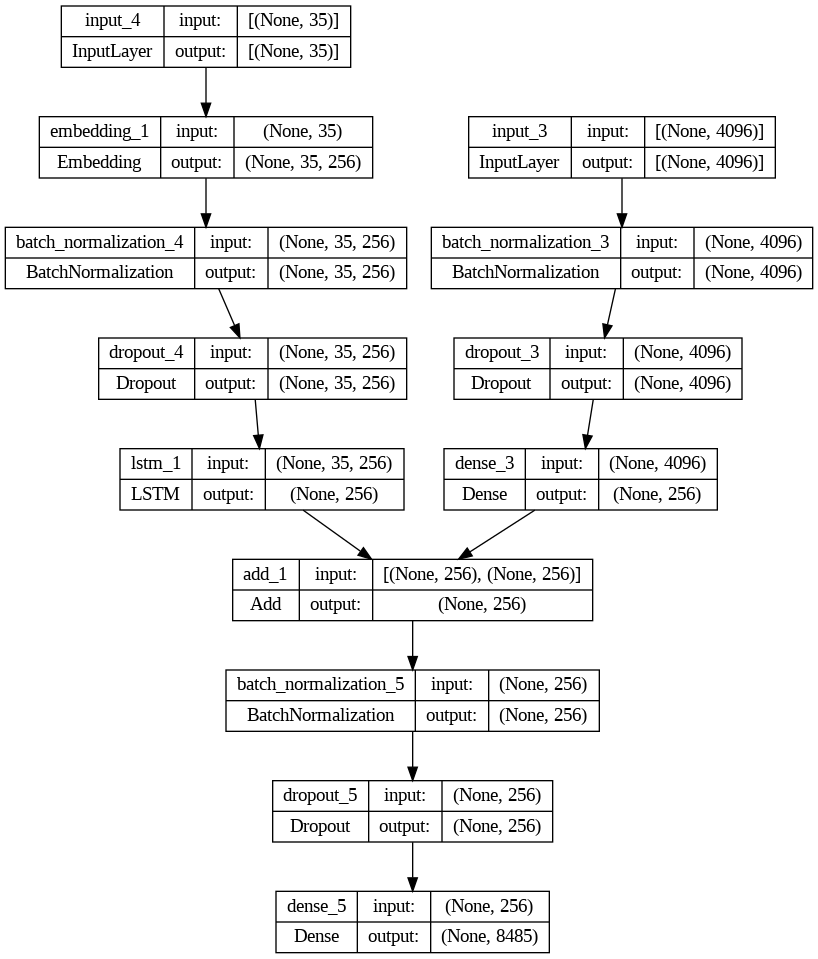

In [68]:
plot_model(model2, show_shapes=True)

In [69]:
model3 = load_model('/content/drive/MyDrive/Data Science Datasets/Image_Caption_Genreation_Model_4.h5')

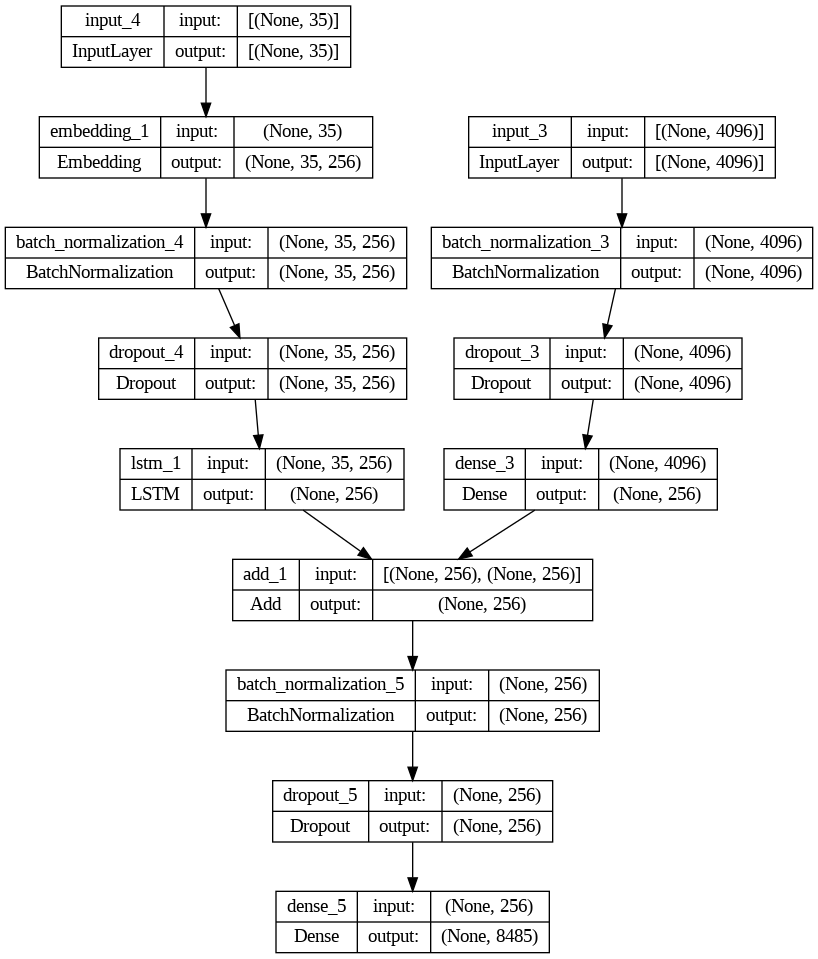

In [70]:
plot_model(model3, show_shapes=True)

In [71]:
vgg_model = VGG16()
vgg_model = Model(inputs=vgg_model.inputs, outputs=vgg_model.layers[-2].output)

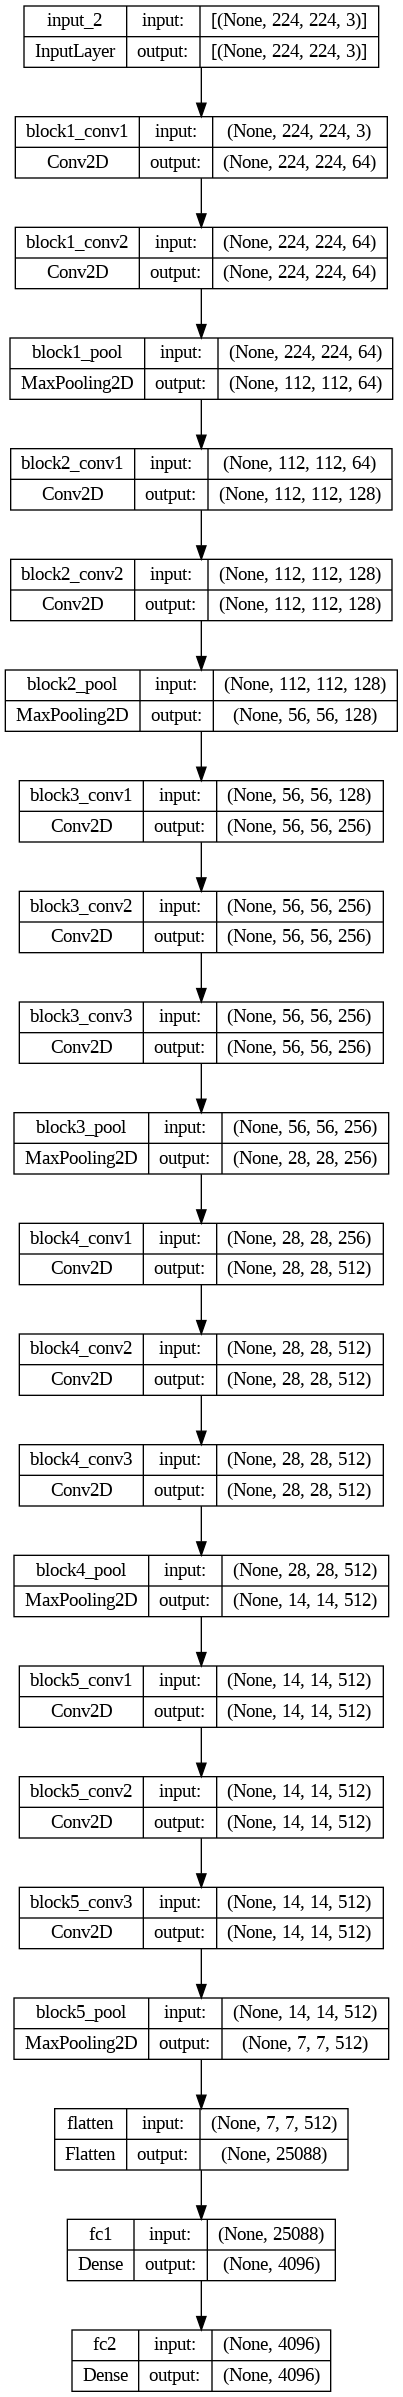

In [72]:
plot_model(vgg_model, show_shapes=True)

In [73]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [74]:
## Generate Caption fo an image

def predict_caption(model, image, tokenizer, max_length):
    in_text = 'nstartn'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], max_length)
        yhat = model.predict([image, sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = idx_to_word(yhat, tokenizer)
        if word is None:
            break
        in_text += " " + word
        if word == 'nendn':
            break
    return in_text

In [75]:
from nltk.translate.bleu_score import corpus_bleu

actual, predicted = list(), list()

for key in tqdm(test):
    captions = mapping[key]
    y_pred = predict_caption(model3, features[key], tokenizer, max_length)
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    actual.append(actual_captions)
    predicted.append(y_pred)
    
print(f"BLEU-1 {corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0))}")
print(f"BLEU-2 {corpus_bleu(actual, predicted, weights=(.5, 0.5, 0, 0))}")

  0%|          | 0/810 [00:00<?, ?it/s]

BLEU-1 0.5367853290183388
BLEU-2 0.30747391060350376


In [76]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name, model):
    image_id = image_name.split('.')[0]
    img_path = '/content/drive/MyDrive/Data Science Datasets/1003163366_44323f5815.jpg'
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('------------------------------Actual----------------------------')
    for caption in captions:
        print(caption)
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('------------------------------Predicted-------------------------')
    print(y_pred)
    plt.imshow(image)

------------------------------Actual----------------------------
nstartn man lays on bench while his dog sits by him nendn
nstartn man lays on the bench to which white dog is also tied nendn
nstartn man sleeping on bench outside with white and black dog sitting next to him nendn
nstartn shirtless man lies on park bench with his dog nendn
nstartn man laying on bench holding leash of dog sitting on ground nendn
------------------------------Predicted-------------------------
nstartn broken broken broken broken broken broken broken broken broken broken broken broken broken broken broken broken broken broken broken broken broken broken broken broken broken broken broken broken broken broken broken broken broken broken broken


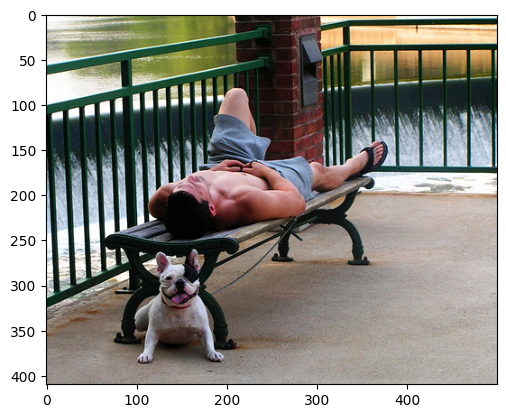

In [77]:
generate_caption('1003163366_44323f5815.jpg', model1)

------------------------------Actual----------------------------
nstartn man lays on bench while his dog sits by him nendn
nstartn man lays on the bench to which white dog is also tied nendn
nstartn man sleeping on bench outside with white and black dog sitting next to him nendn
nstartn shirtless man lies on park bench with his dog nendn
nstartn man laying on bench holding leash of dog sitting on ground nendn
------------------------------Predicted-------------------------
nstartn man lays on bench with his dog in the air nendn


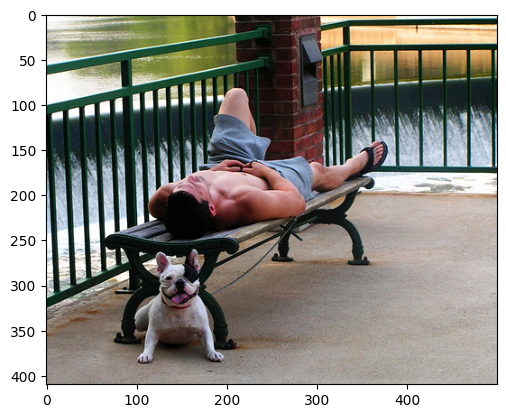

In [78]:
generate_caption('1003163366_44323f5815.jpg', model2)

------------------------------Actual----------------------------
nstartn man lays on bench while his dog sits by him nendn
nstartn man lays on the bench to which white dog is also tied nendn
nstartn man sleeping on bench outside with white and black dog sitting next to him nendn
nstartn shirtless man lies on park bench with his dog nendn
nstartn man laying on bench holding leash of dog sitting on ground nendn
------------------------------Predicted-------------------------
nstartn man lays on bench with his feet in the air nendn


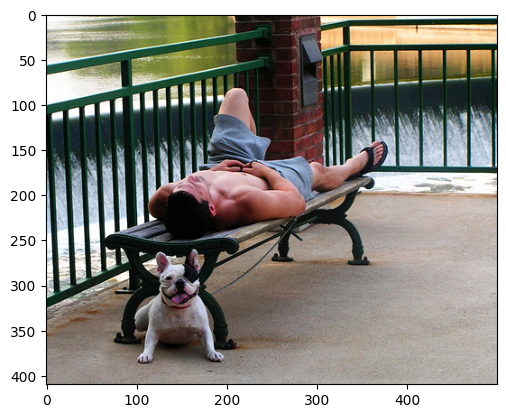

In [79]:
generate_caption('1003163366_44323f5815.jpg', model3)

In [80]:
image = cv2.imread('/content/benchwithmen.jpg')

In [81]:
image

array([[[172, 152, 141],
        [161, 143, 132],
        [153, 134, 126],
        ...,
        [ 54,  61,  46],
        [ 61,  71,  54],
        [ 70,  80,  63]],

       [[173, 153, 142],
        [164, 144, 133],
        [153, 134, 126],
        ...,
        [ 58,  66,  49],
        [ 65,  75,  58],
        [ 73,  84,  64]],

       [[174, 155, 142],
        [165, 146, 133],
        [154, 136, 125],
        ...,
        [ 65,  73,  56],
        [ 71,  82,  62],
        [ 77,  90,  68]],

       ...,

       [[180, 182, 190],
        [179, 181, 189],
        [183, 185, 193],
        ...,
        [150, 169, 190],
        [139, 156, 177],
        [104, 124, 142]],

       [[200, 200, 206],
        [191, 191, 197],
        [185, 185, 191],
        ...,
        [178, 199, 220],
        [157, 177, 195],
        [109, 132, 148]],

       [[183, 183, 189],
        [187, 187, 193],
        [197, 197, 203],
        ...,
        [151, 173, 191],
        [152, 174, 192],
        [107, 130, 146]]

In [82]:
image = cv2.resize(image, (224, 224))

In [83]:
input_image = image.reshape((1, 224, 224, 3))

In [84]:
feature = vgg_model.predict(input_image)

1/1 [==============================] - 1s 786ms/step


In [85]:
feature

array([[0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [86]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_feature, model, image):
    image = cv2.imread(image)
    image = cv2.resize(image, (224, 224))
    y_pred = predict_caption(model, image_feature, tokenizer, max_length)
    print('------------------------------Predicted-------------------------')
    print(y_pred)
    plt.imshow(image)

------------------------------Predicted-------------------------
nstartn young girl in park bench nendn


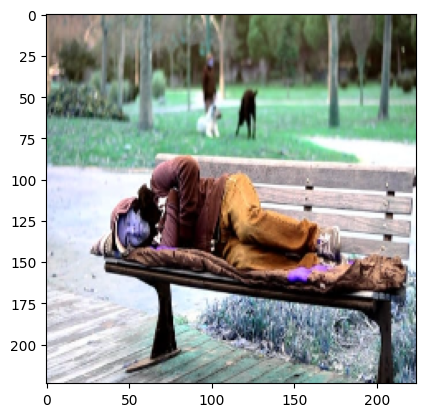

In [87]:
generate_caption(feature, model2, '/content/benchwithmen.jpg')

In [88]:
def extract_feature(model, image):
  image = cv2.imread(image)
  image = cv2.resize(image, (224, 224))
  input_image = image.reshape((1, 224, 224, 3))
  feature = model.predict(input_image)
  return feature

In [89]:
feature2 = extract_feature(vgg_model, '/content/image.jpg')

1/1 [==============================] - 1s 648ms/step


------------------------------Predicted-------------------------
nstartn four guys and one man posing for picture nendn


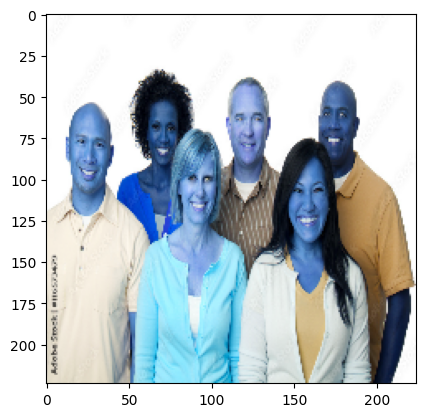

In [90]:
generate_caption(feature2, model2, '/content/image.jpg')

In [ ]:
generate_caption(feature2, model3, '/content/image.jpg')

1/1 [==============================] - 1s 536ms/step
------------------------------Predicted-------------------------
nstartn two children are skateboarding on wooden bench nendn


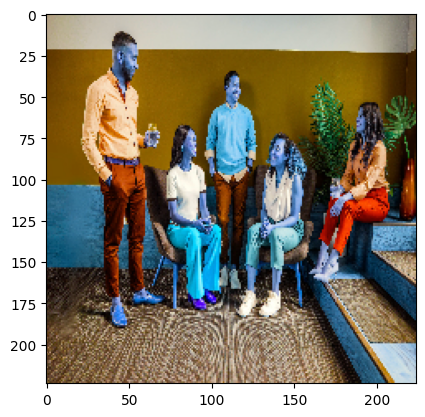

In [92]:
generate_caption(extract_feature(vgg_model,'/content/group.jpg'), model2, '/content/group.jpg')

In [ ]:
generate_caption(extract_feature(vgg_model,'/content/group.jpg'), model3, '/content/group.jpg')

1/1 [==============================] - 1s 1s/step
------------------------------Predicted-------------------------
nstartn woman in black and white dress walks next to woman in black dress nendn


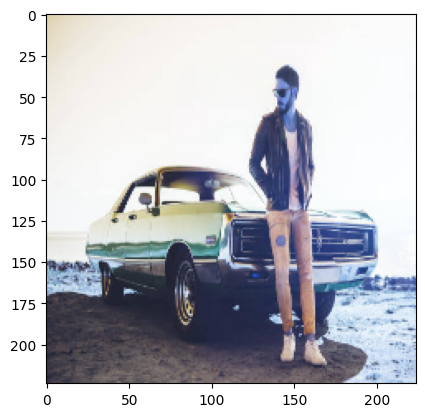

In [94]:
generate_caption(extract_feature(vgg_model,'/content/manwithcar.jpg'), model3, '/content/manwithcar.jpg')

In [ ]:
generate_caption(extract_feature(vgg_model,'/content/manonbench.jpg'), model2, '/content/manonbench.jpg')

1/1 [==============================] - 1s 535ms/step
------------------------------Predicted-------------------------
nstartn man in jeans sits on bench in front of building nendn


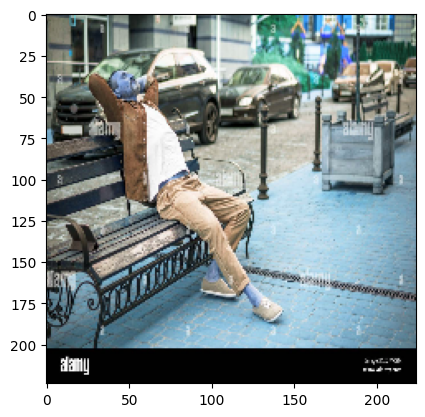

In [96]:
generate_caption(extract_feature(vgg_model,'/content/manonbench.jpg'), model3, '/content/manonbench.jpg')